In [1]:
#Importing the data
import pandas as pd
import numpy as np
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans, accuracy, PredictionImpossible
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from collections import defaultdict
#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
data.head()
# Create an empty DataFrame
metrics_df = pd.DataFrame(columns=['Index','Model','RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [2]:
class Knn (KNNWithMeans):
    def __init__(self, sim_options={}, bsl_options = {}):#, bsl_options={}):
        KNNWithMeans.__init__(self, sim_options=sim_options, bsl_options= bsl_options)#, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
    # # option 1
    # ########################################
    # # for cross validation we have two functions, cross_validate and fit
    # def cross_validate(self, measures=['RMSE'], cv=3, verbose=False):
    #     results = cross_validate(self, self.data, measures=measures, cv=cv, verbose=verbose)
    #     for measure in measures:
    #         print(f'{measure}: {results["test_" + measure.lower()].mean()}')
    #     return results
    
    # def fit(self, trainset):
    #     predictions = KNNWithMeans.fit(self, trainset).test(trainset.build_testset())
    #     self.sim = self.compute_similarities()
    #     self.bu, self.bi = self.compute_baselines()
    #     return predictions
    ########################################
    #option 2
    #######################################
    # fit funtion that works without cross validation
    def fit (self):
        self.trainset, testset = train_test_split(self.data, test_size=0.2)
        predictions = KNNWithMeans.fit(self, self.trainset).test(testset)
        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    #######################################

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        # Compute similarities between u and v, where v describes all other
        # users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        # Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        
        # Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)
        
        # Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        # Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        # Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        # Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        # Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
    ########################################
    # def get_accuracy(self, predictions, k=10, threshold=3.5):
    #     # Compute RMSE
    #     accuracy.rmse(predictions, verbose=True)
        
    #     # Compute precision and recall
    #     precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

    #     # Precision and recall can then be averaged over all users
    #     precision = sum(prec for prec in precisions.values()) / len(precisions)
    #     recall = sum(rec for rec in recalls.values()) / len(recalls)
    #     print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

    #     # Count correct predictions
    #     correct = 0
    #     for uid, iid, true_r, est, _ in predictions:
    #         if round(est) == round(true_r):
    #             correct += 1

    #     # Compute accuracy
    #     accuracy_percentage = correct / len(predictions)
    #     accuracy_percentage = accuracy_percentage * 100
    #     print(f"the acc is {accuracy_percentage:.2f}")
    #     return accuracy_percentage
    
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""

        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():

            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.

            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        return precisions, recalls
    
    # Mi function acc that works perfectly was modifyed to add precision and recall, for that reason this is commented
    # def get_accuracy(self, predictions):
    #     # # Compute RMSE
    #     # predictions = KNNBasic.test(self, testset)
    #     accuracy.rmse(predictions, verbose=True)
    #     # Count correct predictions
    #     correct = 0
    #     for uid, iid, true_r, est, _ in predictions:
    #         if round(est) == round(true_r):
    #             correct += 1

    #     # Compute accuracy
    #     accuracy_percentage = correct / len(predictions)
    #     return accuracy_percentage * 100

## KnnWithMeans and SGD

* 1 Cosine UserBased

In [3]:
knn = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn.create_reader(data)
# cross validate
predictions = knn.fit()
# acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithMeans (cosine, sgd, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.3685
MAE:  1.0440
MSE: 1.8727
Precision: 0.09
Recall: 0.07
the acc is 33.51


/tmp/ipykernel_29375/169629797.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 2 Cosine ItemBased

In [4]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn2.create_reader(data)
# cross validate
predictions = knn2.fit()
# acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithMeans (cosine, sgd, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.5342
MAE:  1.1785
MSE: 2.3537
Precision: 0.08
Recall: 0.05
the acc is 28.80


/tmp/ipykernel_29375/3543638896.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 3 Mean Square DIfference UserBased

In [5]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn3.create_reader(data)
# cross validate
predictions = knn3.fit()
# acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithMeans (mean square diff, sgd, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4179
MAE:  1.1125
MSE: 2.0105
Precision: 0.05
Recall: 0.03
the acc is 28.27


/tmp/ipykernel_29375/2189425315.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 4 Mean Square DIfference ItemBased

In [6]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn4.create_reader(data)
# cross validate
predictions = knn4.fit()
# acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithMeans (mean square diff, sgd, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4996
MAE:  1.1340
MSE: 2.2489
Precision: 0.09
Recall: 0.06
the acc is 32.98


/tmp/ipykernel_29375/2602642850.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 4 the Pearson correlation coefficient UserBased

In [7]:
knn5 = Knn(
    sim_options = {'name': 'Pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn5.create_reader(data)
# cross validate
predictions = knn5.fit()
# acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithMeans (pearson corr coeff, sgd, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.3229
MAE:  0.9898
MSE: 1.7500
Precision: 0.09
Recall: 0.07
the acc is 31.41


/tmp/ipykernel_29375/3861551723.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 5 the Pearson correlation coefficient ItemBased

In [8]:
knn6 = Knn(
    sim_options = {'name': 'Pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
# create reader
knn6.create_reader(data)
# cross validate
predictions = knn6.fit()
# acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithMeans (pearson corr coeff, sgd, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...


/tmp/ipykernel_29375/546500276.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.5214
MAE:  1.0772
MSE: 2.3148
Precision: 0.10
Recall: 0.06
the acc is 37.17


* 6 the (shrunk) Pearson correlation coefficient UserBased

In [9]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn7.create_reader(data)
# cross validate
predictions = knn7.fit()
# acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithMeans (pearson_baseline, sgd, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.4160
MAE:  1.0891
MSE: 2.0051
Precision: 0.08
Recall: 0.06
the acc is 29.32


/tmp/ipykernel_29375/2965504438.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 7 the (shrunk) Pearson correlation coefficient ItemBased

In [10]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn8.create_reader(data)
# cross validate
predictions = knn8.fit()
# acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithMeans (pearson_baseline, sgd, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.4649
MAE:  1.0868
MSE: 2.1459
Precision: 0.08
Recall: 0.05
the acc is 31.94


/tmp/ipykernel_29375/3870639353.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithMeans and ALS


* 1 Cosine UserBased

In [11]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
# create reader
knn9.create_reader(data)
# cross validate
predictions = knn9.fit()
# acc
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithMeans (cosine, als, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.4797
MAE:  1.1599
MSE: 2.1896
Precision: 0.10
Recall: 0.09
the acc is 27.23


/tmp/ipykernel_29375/2042837302.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 2 Cosine ItemBased

In [12]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn10.create_reader(data)
# cross validate
predictions = knn10.fit()
# acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithMeans (cosine, als, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.5967
MAE:  1.2575
MSE: 2.5494
Precision: 0.07
Recall: 0.05
the acc is 27.23


/tmp/ipykernel_29375/194871798.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 3 Mean Square Difference UserBased

In [13]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
# create reader
knn11.create_reader(data)
# cross validate
predictions = knn11.fit()
# acc
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithMeans (mean square diff, als, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.4549
MAE:  1.1205
MSE: 2.1166
Precision: 0.07
Recall: 0.05
the acc is 29.84


/tmp/ipykernel_29375/1238153130.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 4 Mean Square Difference ItemBased

In [14]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
# create reader
knn12.create_reader(data)
# cross validate
predictions = knn12.fit()
# acc
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithMeans (mean square diff, als, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.5078
MAE:  1.1206
MSE: 2.2735
Precision: 0.09
Recall: 0.06
the acc is 34.03


/tmp/ipykernel_29375/1118245004.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 5 Pearson correlation coefficient UserBased

In [15]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
# create reader
knn13.create_reader(data)
# cross validate
predictions = knn13.fit()
# acc
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithMeans (pearson corr coeff, als, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.3819
MAE:  1.0376
MSE: 1.9097
Precision: 0.09
Recall: 0.07
the acc is 32.98


/tmp/ipykernel_29375/3678973049.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 6 Pearson correlation coefficient ItemBased

In [16]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
# create reader
knn14.create_reader(data)
# cross validate
predictions = knn14.fit()
# acc
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithMeans (pearson corr coeff, als, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.6116
MAE:  1.2003
MSE: 2.5972
Precision: 0.07
Recall: 0.06
the acc is 31.41


/tmp/ipykernel_29375/872247341.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 7 the (shrunk) Pearson correlation coefficient UsedBased

In [17]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
# create reader
knn15.create_reader(data)
# cross validate
predictions = knn15.fit()
# acc
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithMeans (pearson_baseline, als, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.4961
MAE:  1.1110
MSE: 2.2383
Precision: 0.07
Recall: 0.06
the acc is 30.37


/tmp/ipykernel_29375/1286608646.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 8 the (shrunk) Pearson correlation coefficient ItemBased

In [18]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
# create reader
knn16.create_reader(data)
# cross validate
predictions = knn16.fit()
# acc
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithMeans (pearson_baseline, als, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.6339
MAE:  1.1571
MSE: 2.6697
Precision: 0.09
Recall: 0.08
the acc is 37.70


/tmp/ipykernel_29375/3921582843.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [19]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df


,Index,Model,RMSE,MAE,MSE,Precision,Recall,Accuracy
4,5,"KnnWithMeans (pearson corr coeff, sgd, user_ba...",1.322879,0.989803,1.750010,0.090535,0.070165,31.413613
0,1,"KnnWithMeans (cosine, sgd, user_based)",1.368476,1.043970,1.872726,0.091011,0.073328,33.507853
12,13,"KnnWithMeans (pearson corr coeff, als, user_ba...",1.381916,1.037629,1.909693,0.093333,0.072444,32.984293
6,7,"KnnWithMeans (pearson_baseline, sgd, user_based)",1.416003,1.089122,2.005065,0.084416,0.056066,29.319372
2,3,"KnnWithMeans (mean square diff, sgd, user_based)",1.417930,1.112531,2.010524,0.052209,0.029652,28.272251
10,11,"KnnWithMeans (mean square diff, als, user_based)",1.454869,1.120516,2.116643,0.071429,0.048753,29.842932
7,8,"KnnWithMeans (pearson_baseline, sgd, item_based)",1.464894,1.086838,2.145914,0.075556,0.053333,31.937173
8,9,"KnnWithMeans (cosine, als, user_based)",1.479718,1.159865,2.189566,0.096154,0.087607,27.225131
14,15,"KnnWithMeans (pearson_baseline, als, user_based)",1.496108,1.111036,2.238340,0.066260,0.060467,30.366492
3,4,"KnnWithMeans (mean square diff, sgd, item_based)",1.499630,1.133972,2.248889,0.093023,0.057558,32.984293


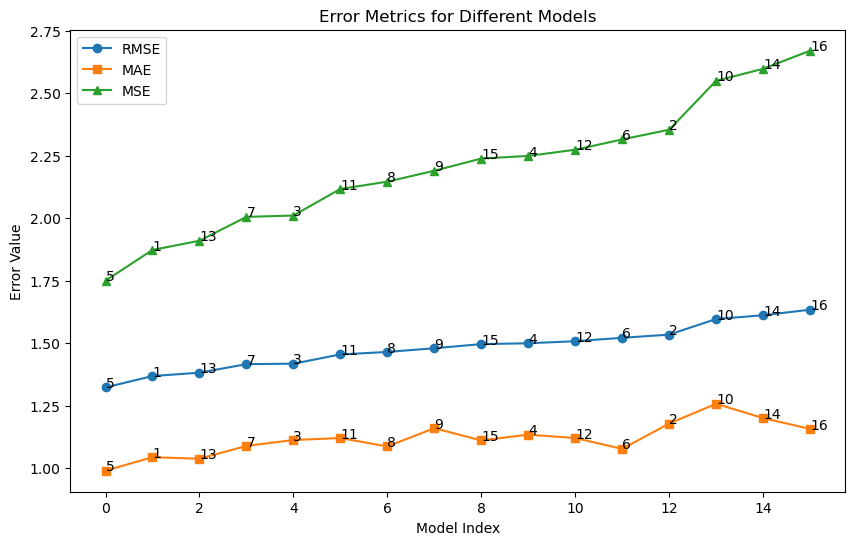

In [20]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

# Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

# Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

# Set title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()

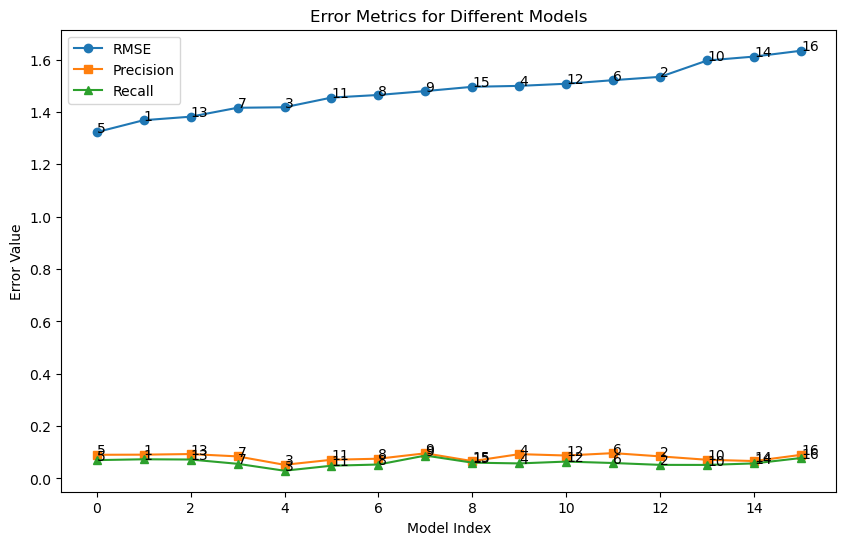

In [21]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

# Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

# Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

# Set title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()

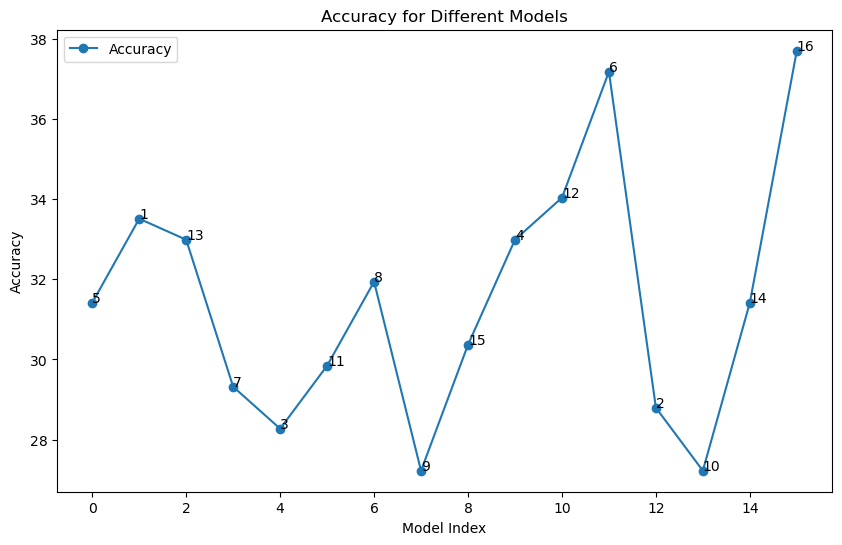

In [22]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

# Set title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Show the plot
plt.show()
